In [1]:
!pip install torchsummary
!pip install yuface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 kB 16.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2

from matplotlib import pyplot as plt

import torch
import torchvision
from torchsummary import summary
from torch.nn.functional import normalize

from yuface import detect

from torchvision.models import efficientnet_b2

from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from PIL import Image

import time
import os
import glob
import gc

In [3]:
cascade_classifier = cv2.CascadeClassifier('/kaggle/input/haar-resources/haarcascade_frontalface_default.xml')

def predict_face_haar(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cascade_classifier.detectMultiScale(image=image_gray, scaleFactor=1.1,
minNeighbors=5)

def predict_face_yu(image):
    return detect(image)[1]

def predict_face_plot(image, method=predict_face_haar):
    image = image.copy()
    for x, y, w, h in method(image):
        image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    plt.imshow(image)

In [4]:
def imread(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
image = imread('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima101_3.jpg')

CPU times: user 64.5 ms, sys: 7.9 ms, total: 72.4 ms
Wall time: 45.4 ms


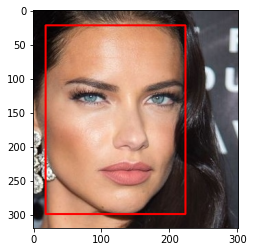

In [6]:
%%time
predict_face_plot(image, predict_face_yu)

In [7]:
resize = torchvision.transforms.Resize((128, 128))
grayscale = torchvision.transforms.Grayscale(num_output_channels=1)
to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

# MAKING DATASET

In [280]:

import warnings
warnings.simplefilter('ignore')

#base1 = '/kaggle/input/indian-actor-images-dataset/Bollywood Actor Images/Bollywood Actor Images'
#base2 = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
#base3 = '/kaggle/input/masked-facerecognition/AFDB_face_dataset/AFDB_face_dataset'
base4 = '/kaggle/input/video-faces3/video_faces'

if not os.path.isdir('celebdata'):
    os.mkdir('celebdata')
    
celeb_id = 0

for base in [base4]:#[base1, base2, base3]:
    print(base)
    for celeb in os.listdir(base):
        print(celeb_id)
        print('+', end='')
        if not os.path.isdir('celebdata/' + str(celeb_id)):
            os.mkdir('celebdata/' + str(celeb_id))
        base_celeb =  base + '/' + celeb
        if len(os.listdir(base_celeb)) < 20:
            pass
            #continue
    
        ind = 0
        for img_path in os.listdir(base_celeb):

            img_path_full = base_celeb + '/' + img_path
            img = cv2.imread(img_path_full)
            faces = predict_face_yu(img)
            if len(faces) == 1:
                x, y, w, h = faces[0]
                x, y = max(0, x), max(0, y)
                img = resize(to_tensor(img[y:y+h, x:x+w]).permute(0, 1, 2)).numpy().transpose(1, 2, 0)
                cv2.imwrite('celebdata' + '/' + str(celeb_id) + '/' + str(ind) + '.jpg', img*255)
                ind += 1
        celeb_id += 1


/kaggle/input/video-faces3/video_faces
0
+1
+2
+3
+4
+5
+

In [281]:
ls celebdata/

0/  1/  2/  3/  4/  5/


In [10]:
"""
import shutil
shutil.make_archive('celebdata', 'zip', '/kaggle/working/celebdata')
""";

# BACK TO CODE

In [11]:
img = resize(torch.FloatTensor(image).permute(2, 0, 1))

In [431]:
class Augmentation:
    def __init__(self):
        self.rotate_transform = torchvision.transforms.RandomRotation((-20, 20))
        self.rescrop_transform = torchvision.transforms.RandomResizedCrop(size=(128, 128), scale=(0.9, 1))
    def flip(self, X):
        return torch.flip(X, [-1])
    def rotate(self, X):
        return self.rotate_transform(X)
    def resize_crop(self, X):
        return self.rescrop_transform(X)
    def aug(self, X):
        return X
        r = np.random.random()
        if r < 0.5:
            X = self.flip(X)
        return self.rotate(self.resize_crop(X))

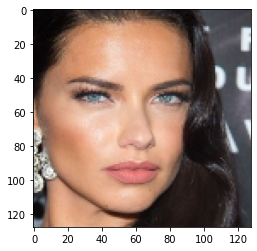

In [13]:
plt.imshow(img.permute(1, 2, 0)/255)

CPU times: user 192 ms, sys: 21.3 ms, total: 214 ms
Wall time: 201 ms


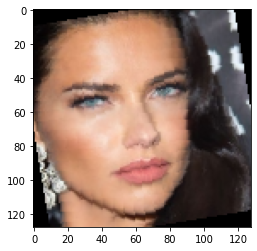

In [14]:
%%time
plt.imshow(Augmentation().aug(img).permute(1, 2, 0)/255)

In [15]:
class FacesDataset(torch.utils.data.Dataset):
    def __init__(self, base='/kaggle/working/celebdata', train=True, train_size=0.9, batch_size = -1):
        self.base = base
        self.faces = os.listdir(base)
        self.bs = batch_size
        self.train = train
        if train:
            self.faces = np.random.permutation(self.faces[:int(len(self.faces)*train_size)])
        else:
            self.faces = self.faces[int(len(self.faces)*train_size):]
        self.aug = Augmentation()
    
    def __len__(self):
        return len(self.faces)
    
    def __getitem__(self, idx):
        if idx >= self.__len__():
            raise StopIteration
        
        sample_size = len(os.listdir(self.base + '/' + self.faces[idx])) if self.bs == -1 else self.bs
        if self.train:
            X = torch.zeros([sample_size, 3, 128, 128])
            imgs = os.listdir(self.base + '/' + self.faces[idx])
            replace_param = False if len(imgs) >= sample_size else True
            for i, img_path in enumerate(np.random.choice(imgs, sample_size, replace=replace_param)):
                X[i] = torch.FloatTensor(imread(self.base + '/' + self.faces[idx] + '/' + img_path)).permute(2, 0, 1)
            X = self.aug.aug(X)
            Y = torch.zeros([sample_size, 3, 128, 128])
            for i in range(len(Y)):
                face = np.random.choice(self.faces)
                while face == self.faces[idx]:
                    face = np.random.choice(self.faces)
                Y[i] = torch.FloatTensor(imread(self.base + '/' + face + '/' + str(np.random.randint(0, len(os.listdir(self.base + '/' + face)))) + '.jpg')).permute(2, 0, 1)
            Y = self.aug.aug(Y)
        
        else:
            X = torch.zeros([sample_size, 3, 128, 128])
            imgs = os.listdir(self.base + '/' + self.faces[idx])
            for i in range(sample_size):
                X[i] = torch.FloatTensor(imread(self.base + '/' + self.faces[idx] + '/' + imgs[i])).permute(2, 0, 1)
                
            Y = torch.zeros([sample_size, 3, 128, 128])
            imgs = os.listdir(self.base + '/' + self.faces[(idx + 1) % self.__len__()])
            for i in range(sample_size):
                Y[i] = torch.FloatTensor(imread(self.base + '/' + self.faces[(idx + 1) % self.__len__()] + '/' + imgs[i])).permute(2, 0, 1)
        return X/255, Y/255

In [16]:
#cd ..

In [17]:
#!cp -R kaggle/input/celeb600 /kaggle/working/

In [26]:
f = FacesDataset(base = '/kaggle/working/celeb600', train_size=0.9, batch_size=-1)
f1 = FacesDataset(base = '/kaggle/working/celeb600', train_size=0.9, batch_size=8, train=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/celeb600'

In [ ]:
plt.imshow(f[100][0][3].permute(1, 2, 0))

In [ ]:
plt.imshow(f1[10][0][0].permute(1,2,0))

In [ ]:
%%time
f[0][0][0].shape

In [ ]:
%%time
f1[0][0][0].shape

In [18]:
device = torch.device('cuda')
cpu_device = torch.device('cpu')

In [19]:
"""
base = '/kaggle/working/celebdata'
data = []
for i in os.listdir(base):
    add = []
    for j in os.listdir(base+'/'+str(i)):
        if int(j[:-4]) > 50:
            continue
        add.append(to_tensor(cv2.cvtColor(cv2.imread(base+'/'+str(i)+'/'+str(j)), cv2.COLOR_BGR2RGB)).to(device))
    data.append(add)
""";

In [20]:
torch.cuda.empty_cache()

In [21]:
#(3, 128, 128) -> (vector_len)

class FaceNet_v0(torch.nn.Module):
    def __init__(self, vector_len=128):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 2, 8, 2)
        self.conv2 = torch.nn.Conv2d(2, 2, 8, 1)
        self.conv3 = torch.nn.Conv2d(2, 2, 8, 1)
        self.conv4 = torch.nn.Conv2d(2, 2, 7, 1)
        self.conv5 = torch.nn.Conv2d(2, 2, 7, 1)
        self.conv6 = torch.nn.Conv2d(2, 2, 7, 1)
        self.conv7 = torch.nn.Conv2d(2, 2, 6, 1)
        self.conv8 = torch.nn.Conv2d(2, 2, 5, 1)
        self.conv9 = torch.nn.Conv2d(2, 2, 5, 1)
        self.conv10 = torch.nn.Conv2d(2, 2, 4, 1)
        
        self.conv11 = torch.nn.Conv2d(2, 2, 4, 1)
        self.conv12 = torch.nn.Conv2d(2, 4, 4, 1)
        
        self.linear = torch.nn.Linear(196, vector_len)
        
        self.act = torch.nn.SiLU()
        self.flat = torch.nn.Flatten(1)
    def forward(self, X):
        X = self.act(self.conv1(X))
        X = self.act(self.conv2(X))
        X = self.act(self.conv3(X))
        X = self.act(self.conv4(X))
        X = self.act(self.conv5(X))
        X = self.act(self.conv6(X))
        X = self.act(self.conv7(X))
        X = self.act(self.conv8(X))
        X = self.act(self.conv9(X))
        X = self.act(self.conv10(X))
        X = self.act(self.conv11(X))
        X = self.conv12(X)
        
        X = self.flat(X)
        X = self.linear(self.act(X))
        return normalize(X)

In [22]:
summary(FaceNet_v0(128).to(device), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 61, 61]             386
              SiLU-2            [-1, 2, 61, 61]               0
            Conv2d-3            [-1, 2, 54, 54]             258
              SiLU-4            [-1, 2, 54, 54]               0
            Conv2d-5            [-1, 2, 47, 47]             258
              SiLU-6            [-1, 2, 47, 47]               0
            Conv2d-7            [-1, 2, 41, 41]             198
              SiLU-8            [-1, 2, 41, 41]               0
            Conv2d-9            [-1, 2, 35, 35]             198
             SiLU-10            [-1, 2, 35, 35]               0
           Conv2d-11            [-1, 2, 29, 29]             198
             SiLU-12            [-1, 2, 29, 29]               0
           Conv2d-13            [-1, 2, 24, 24]             146
             SiLU-14            [-1, 2,

In [23]:
torch.cat([torch.FloatTensor(1, 3, 12, 12), torch.FloatTensor(1, 3, 12, 12)], axis=1).shape

torch.Size([1, 6, 12, 12])

In [24]:
#(3, 128, 128) -> (vector_len)
class DenseBlock(torch.nn.Module):
    def __init__(self, conv_params):
        """
        conv_params: list of torch.nn.Conv2d params representing a sequence for Conv2d modules
        """
        super().__init__()
        self.convs = torch.nn.ModuleList([torch.nn.Conv2d(*i) for i in conv_params])
        self.act = torch.nn.SiLU()
        
    def forward(self, X):
        X = self.convs[0](X)
        concat_maps = [X]
        for i in range(1, len(self.convs)):
            X = self.act(X)
            resize_t = torchvision.transforms.Resize((X.shape[-1], X.shape[-1]))
            X = torch.cat([torch.mean(torch.stack([resize_t(j) for j in concat_maps]), axis=0), X], axis=1)
            X = self.convs[i](X)
            concat_maps.append(X)
        return X

In [25]:
class ParallelBlock(torch.nn.Module):
    def __init__(self, conv_params, shapes_print=False):
        """
        conv_params: 3-d list of torch.nn.Conv2d params representing a sequence for Conv2d modules
        """
        super().__init__()
        self.convs = torch.nn.ModuleList([torch.nn.ModuleList([DenseBlock(j) for j in i]) for i in conv_params])
        self.act = torch.nn.SiLU()
        self.shapes_print = shapes_print
        
        #self.convs [path] [block]
    def forward(self, X):
        X_list = [self.convs[i][0](X) for i in range(len(self.convs))]  # first block of every path
        resize_shape = [j.shape[-1] for j in X_list]  # shapes of first block output of every path
        if self.shapes_print:
            print('BLOCK 1:')
            [print(list(i[0].shape), end=' ') for i in X_list]
            print()
        for j in range(1, len(self.convs[0])):
            X = torch.cat([torchvision.transforms.Resize((max(resize_shape), max(resize_shape)))(j) for j in X_list], axis=1)
            X_list = [self.convs[i][j](torchvision.transforms.Resize((resize_shape[i], resize_shape[i]))(self.act(X))) for i in range(len(self.convs))]
            resize_shape = [j.shape[-1] for j in X_list]
            if self.shapes_print:
                print(f'BLOCK {j+1}:')
                [print(list(i[0].shape), end=' ') for i in X_list]
                print()
        X = torch.cat([torchvision.transforms.Resize((int(np.median(resize_shape)), int(np.median(resize_shape))))(j) for j in X_list], axis=1)
        
        return X

In [26]:
a = [
    # path 1
    [
      # block 1
      [[3, 16, 8, 2],
      [32, 16, 6],
      [32, 16, 6],
      [32, 16, 5],
      [32, 16, 5]],
      # block 2
      [[48, 16, 4],
      [32, 16, 4],
      [32, 16, 4],
      [32, 16, 3],
      [32, 16, 3]]
    ],
    # path 2
    [
      # block 1
      [[3, 16, 8, 2],
      [32, 16, 8],
      [32, 16, 8],
      [32, 16, 8],
      [32, 16, 8]],
      # block 2
      [[48, 16, 7],
      [32, 16, 7],
      [32, 16, 6],
      [32, 16, 6],
      [32, 16, 5]]
    ],
    # path 3
    [
      # block 1
      [[3, 16, 4],
      [32, 16, 4],
      [32, 16, 4],
      [32, 16, 4],
      [32, 16, 4]],
      # block 2
      [[48, 16, 4],
      [32, 16, 3],
      [32, 16, 3],
      [32, 16, 3],
      [32, 16, 2]]
    ]
]

len(a), len(a[0])

(3, 2)

In [27]:
p = ParallelBlock(a, shapes_print=True)

In [28]:
p(torch.FloatTensor(1, 3, 128, 128)).shape

BLOCK 1:
[16, 43, 43] [16, 33, 33] [16, 113, 113] 
BLOCK 2:
[16, 30, 30] [16, 7, 7] [16, 103, 103] 


torch.Size([1, 48, 30, 30])

In [29]:
#(3, 128, 128) -> (vector_len)

class FaceNet_v2(torch.nn.Module):
    def __init__(self, vector_len=128):
        super().__init__()
        
        self.backbone1 = ParallelBlock([
            # path 1
            [
              # block 1
              [[3, 16, 8, 2],
              [32, 16, 6],
              [32, 16, 6],
              [32, 16, 5],
              [32, 16, 5]],
              # block 2
              [[48, 16, 4],
              [32, 16, 4],
              [32, 16, 4],
              [32, 16, 3],
              [32, 16, 3]]
            ],
            # path 2
            [
              # block 1
              [[3, 16, 8, 2],
              [32, 16, 8],
              [32, 16, 8],
              [32, 16, 8],
              [32, 16, 8]],
              # block 2
              [[48, 16, 7],
              [32, 16, 7],
              [32, 16, 6],
              [32, 16, 6],
              [32, 16, 5]]
            ],
            # path 3
            [
              # block 1
              [[3, 16, 4],
              [32, 16, 4],
              [32, 16, 4],
              [32, 16, 4],
              [32, 16, 4]],
              # block 2
              [[48, 16, 4],
              [32, 16, 3],
              [32, 16, 3],
              [32, 16, 3],
              [32, 16, 2]]
            ]
            ])
        
        self.backbone2 = DenseBlock([
              [48, 16, 5],
              [32, 16, 4],
              [32, 16, 4],
              [32, 16, 4],
              [32, 2, 3]
            ])

        self.linear = torch.nn.Linear(450, vector_len)
        
        self.act = torch.nn.SiLU()
        self.flat = torch.nn.Flatten(1)
    def forward(self, X):
        X = self.act(self.backbone1(X))
        X = self.backbone2(X)
        X = self.flat(X)
        X = self.linear(self.act(X))
        return normalize(X)

In [30]:
#(3, 128, 128) -> (vector_len)

class FaceNet_v0(torch.nn.Module):
    def __init__(self, vector_len=128):
        super().__init__()
        
        self.backbone1 = ParallelBlock([
            # path 1
            [
              # block 1
              [[3, 2, 8, 2],
              [4, 2, 6],
              [4, 2, 6],
              [4, 2, 5],
              [4, 2, 5]],
              # block 2
              [[4, 2, 4],
              [4, 2, 4],
              [4, 2, 4],
              [4, 2, 3],
              [4, 2, 3]]
            ],
            # path 2
            [
              # block 1
              [[3, 2, 8, 2],
              [4, 2, 8],
              [4, 2, 8],
              [4, 2, 8],
              [4, 2, 8]],
              # block 2
              [[4, 2, 7],
              [4, 2, 7],
              [4, 2, 6],
              [4, 2, 6],
              [4, 2, 5]]
            ],
            ])
        
        self.backbone2 = DenseBlock([
              [4, 2, 5],
              [4, 2, 4],
            ])

        self.linear = torch.nn.Linear(242, vector_len)
        
        self.act = torch.nn.SiLU()
        self.flat = torch.nn.Flatten(1)
    def forward(self, X):
        X = self.act(self.backbone1(X))
        X = self.backbone2(X)
        X = self.flat(X)
        X = self.linear(self.act(X))
        return normalize(X)

In [31]:
%%time
FaceNet_v0()(torch.rand(1, 3, 128, 128)).shape

CPU times: user 53.2 ms, sys: 1.2 ms, total: 54.4 ms
Wall time: 39.8 ms


torch.Size([1, 128])

In [433]:
def alpha_f(step):
    if step < 200:
        return 0.1
    if step < 400:
        return 0.3
    return 0.4

In [497]:
def step_lr(step):
    return 4e-5
    if step < 5000:
        return 5e-6
    if step < 10000:
        return 99*step/1000000000-49/100000
    if step < 100000:
        return 0.000772226*np.exp(-0.0000434669*step)
    else:
        return 1e-5


In [35]:
ls kaggle/working

ls: cannot access 'kaggle/working': No such file or directory


In [44]:
#torch.save(best_model, 'kaggle/working/facenet_v0_w2.pth')

<a href='facenet_v0_w2.pth'>aeafw</a>

In [185]:
vectorizer = FaceNet_v0(128)
vectorizer.load_state_dict(torch.load('/kaggle/input/models2/facenet_v0_w2.pth'))
vectorizer.to(device);

In [575]:
## CONFIG
epochs = 500
loss_f = torch.nn.CosineSimilarity(dim=1)
batch_size = 4
train_size = 1

lr = 1e-5

## MODEL/OPT CONFIG
vectorizer = FaceNet_v0(128)
vectorizer.load_state_dict(torch.load('/kaggle/input/models2/facenet_v0_w2.pth'))
vectorizer.to(device)
opt = torch.optim.Adam(vectorizer.parameters(), lr=lr)

## LOG/INFO DATA SETTING
#---------------
iters_step = 20
#---------------
steps = 0
losses_different, losses_similar = [], []
loss_sum, loss_sum_similar, loss_sum_different = 0, 0 ,0

## TESTING PARAMS
#---------------------
TEST = False
save_best_model = True
#---------------------
best_test_metric = 1000
best_model = None
test_losses = []

for epoch in range(epochs):
    print('>>>>> Epoch: ', epoch)
    
    #####  TRAIN  #########################################
    
    vectorizer.train()
    
    for X, Y in FacesDataset(base='/kaggle/working/celebdata', train=True, train_size=train_size, batch_size=batch_size):
            
        opt.lr = step_lr(steps)    
            
        X, Y = X.to(device), Y.to(device)
        X_vector, Y_vector = vectorizer(X), vectorizer(Y)
        loss_similar = 1+torch.mean(-loss_f(X_vector, X_vector[torch.randperm(len(X_vector))]))
        loss_different = 1+torch.mean(loss_f(X_vector, Y_vector))
        alpha = alpha_f(steps)
        loss = alpha*loss_similar + (1-alpha)*loss_different
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        del X, Y, X_vector, Y_vector
        torch.cuda.empty_cache()
        
        losses_different.append(loss_different.detach().cpu().numpy())
        losses_similar.append(loss_similar.detach().cpu().numpy())
        loss_sum += (loss_different + loss_similar).detach().cpu().numpy()
        loss_sum_different += loss_different.detach().cpu().numpy()
        loss_sum_similar += loss_similar.detach().cpu().numpy()
        
        steps+=1
        if steps and not steps % iters_step:
            print('TOTAL: ' + '{:.10f}'.format(loss_sum / iters_step), end=' DIF: ')
            print('{:.3f}'.format(loss_sum_different / iters_step), end=' SIM: ')
            print('{:.3f}'.format(loss_sum_similar / iters_step))
            loss_sum, loss_sum_different, loss_sum_similar = 0, 0, 0
    
    #####  TEST  ##########################################
    
    if not TEST: continue
    
    vectorizer.eval()
    
    test_loss = 0
    test_steps = 0
    
    for X, Y in FacesDataset(base='/kaggle/working/celeb600', train=False, train_size=train_size, batch_size=32):
        
        X, Y = X.to(device), Y.to(device)
        X_vector, Y_vector = vectorizer(X), vectorizer(Y)
        loss_similar = 1+torch.mean(-loss_f(X_vector, X_vector[torch.randperm(len(X_vector))]))
        loss_different = 1+torch.mean(loss_f(X_vector, Y_vector))
        loss = (loss_similar + loss_different).detach().cpu().numpy()
        
        test_loss += loss
        test_steps += 1
        
        del X, Y, X_vector, Y_vector
        torch.cuda.empty_cache()
    
    if test_loss/test_steps < best_test_metric and save_best_model:
        best_model = vectorizer.state_dict()
        best_test_metric = test_loss/test_steps
        print('NEW BEST MODEL')
    test_losses.append(test_loss/test_steps)
    print('TOTAL (TEST): ' + '{:.3f}'.format(test_loss/test_steps))

>>>>> Epoch:  0
>>>>> Epoch:  1
>>>>> Epoch:  2
>>>>> Epoch:  3
TOTAL: 1.9401636302 DIF: 1.888 SIM: 0.053
>>>>> Epoch:  4
>>>>> Epoch:  5
>>>>> Epoch:  6
TOTAL: 1.9280102134 DIF: 1.870 SIM: 0.058
>>>>> Epoch:  7
>>>>> Epoch:  8
>>>>> Epoch:  9
TOTAL: 1.8406000644 DIF: 1.838 SIM: 0.003
>>>>> Epoch:  10
>>>>> Epoch:  11
>>>>> Epoch:  12
>>>>> Epoch:  13
TOTAL: 1.9223281205 DIF: 1.838 SIM: 0.085
>>>>> Epoch:  14
>>>>> Epoch:  15
>>>>> Epoch:  16
TOTAL: 1.8671348870 DIF: 1.865 SIM: 0.002
>>>>> Epoch:  17
>>>>> Epoch:  18
>>>>> Epoch:  19
TOTAL: 1.8806056380 DIF: 1.724 SIM: 0.156
>>>>> Epoch:  20
>>>>> Epoch:  21
>>>>> Epoch:  22
>>>>> Epoch:  23
TOTAL: 1.8529593408 DIF: 1.708 SIM: 0.145
>>>>> Epoch:  24
>>>>> Epoch:  25
>>>>> Epoch:  26
TOTAL: 1.8560692549 DIF: 1.709 SIM: 0.147
>>>>> Epoch:  27
>>>>> Epoch:  28
>>>>> Epoch:  29
TOTAL: 1.7627233654 DIF: 1.700 SIM: 0.063
>>>>> Epoch:  30
>>>>> Epoch:  31
>>>>> Epoch:  32
>>>>> Epoch:  33
TOTAL: 1.9667485654 DIF: 1.768 SIM: 0.198
>>>>> Epoch:

KeyboardInterrupt: 

In [ ]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#ax[0].plot(losses_different)
#ax[0].plot(losses_similar)
ax[0].plot(moving_avg(np.array(losses_different)+np.array(losses_similar), 1000))
ax[1].plot(test_losses)
ax[0].set_title('Train_loss')
ax[1].set_title('Test_loss ##min ' + str('{:.3f}'.format(min(test_losses))))
ax[1].axvline(x = np.argmin(test_losses), color = 'r', linestyle = '-')
fig.show()

$LossDifferent = -\frac{1}{n} \sum_{i}^{n-1}\frac{1}{n} \sum_{j=0;j \not= i}^{n-1}CosSim(v(iden_i[rand(0,m_i+1)]), v(iden_j[rand(0,m_j+1)]))$

In [43]:
def open_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

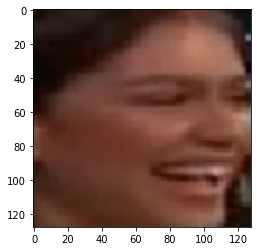

In [540]:
plt.imshow(open_img('/kaggle/working/celebdata/2/12.jpg'))

In [136]:
vidcap = cv2.VideoCapture('/kaggle/input/inputvideo/inputvideo.mp4')
imgs = []
success,image = vidcap.read()
count = 0
while success:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imgs.append(image)
    success,image = vidcap.read()
    count += 1

In [576]:
loss_f = torch.nn.CosineSimilarity(dim=1)

def predict_mask(image, coords):
    if not len(coords): return -1
    th = 0.99
    image = to_tensor(image)
    #x, y = max(0, x), max(0, y)
    images = [resize(image[:, max(0, y):max(0, y)+h, max(0, x):max(0, x)+w]) for x, y, w, h in coords]
    base_image_1 = to_tensor(open_img('/kaggle/working/celebdata/2/12.jpg'))
    base_image_2 = to_tensor(open_img('/kaggle/working/celebdata/2/45.jpg'))
    vectors = vectorizer(torch.stack(images))
    base_vector_1 = vectorizer(base_image_1.unsqueeze(0))
    base_vector_2 = vectorizer(base_image_2.unsqueeze(0))
    scores_1 = loss_f(vectors, base_vector_1)
    scores_2 = loss_f(vectors, base_vector_2)
    scores = 0.5*scores_1 + 0.5*scores_2
    if max(scores) < th: return -1
    return torch.argmax(scores)

[[529  89 215 268]]


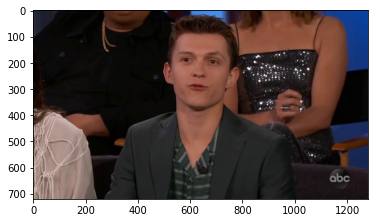

In [595]:
vectorizer.to(torch.device('cpu'));

image = imgs[410].copy()
coords = predict_face_yu(image)
print(coords)
a = predict_mask(image, coords)
if a != -1:
    x, y, w, h = coords[a]
    image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(image)

In [596]:
height, width, layers = imgs[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('out.mp4', fourcc, 30, (width,height))

vectorizer.to(torch.device('cpu'));


for image in imgs:
    print('!', end='')
    image = image.copy()
    coords = predict_face_yu(image)
    a = predict_mask(image, coords)
    
    if a != -1:
        x, y, w, h = coords[a]
        image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#cv2.destroyAllWindows()
video.release()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
predict_mask(image, predict_face_yu(image))

In [111]:
X, Y = FacesDataset(base='/kaggle/working/celeb600', train=False, train_size=train_size, batch_size=32)[0]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/celeb600'

In [ ]:
X, Y = X.to(device), Y.to(device)

In [ ]:
loss_f(vectorizer(X)[8].unsqueeze(0), vectorizer(Y)[10].unsqueeze(0))

In [ ]:
torch.save(vectorizer.state_dict(), 'model_weights.pth')

In [ ]:
def 

Testing

In [ ]:
base_image = to_tensor(open_img('/kaggle/working/celebdata/20/1.jpg'))
base_image = resize(base_image)

In [ ]:
image1 = to_tensor(open_img('/kaggle/working/celebdata/15/4.jpg'))
image1 = resize(image1)

In [ ]:
plt.imshow(image1.numpy().transpose(1, 2, 0))

In [ ]:
plt.imshow(base_image.numpy().transpose(1, 2, 0))

In [ ]:
cos_dist = torch.nn.CosineSimilarity()

In [ ]:
cos_dist(vectorizer(image1.to(device)), vectorizer(base_image.to(device)))

### Making Video

In [ ]:
#vectorizer = Face_vectorizer()
#vectorizer.load_state_dict(torch.load('/kaggle/input/netweights1/model_weights-4.pth'))

In [ ]:
vectorizer.to(cpu_device)

In [ ]:
frames = []
capture = cv2.VideoCapture('/kaggle/input/zendaya-1/zendaya.MOV')
 
frameNr = 0
 
while (True):
    success, frame = capture.read()
    
    if success:
        
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
        break
capture.release()

len(frames)

In [ ]:
def predict_face(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cascade_classifier.detectMultiScale(image=image_gray, scaleFactor=1.1,
minNeighbors=15)

In [ ]:
i=70
image = frames[i].copy()
for x, y, w, h in predict_face(image):
    image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(image)

In [ ]:
marked_frames = []

for frame in frames:
    print(0, end=' ')
    image = frame.copy()
    for x, y, w, h in predict_face(image):
        image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    marked_frames.append(image)

In [ ]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'XVID'), 60, (448, 848))
 
for frame in marked_frames:
    out.write(frame)
out.release()

In [ ]:
marked_frames[0].shape

In [ ]:
frames[0].shape

In [ ]:
for frame in marked_frames:
    break
    plt.imshow(frame)
    plt.show()
    plt.cla()

In [ ]:
plt.imshow(cv2.cvtColor(frames[10], cv2.COLOR_RGB2BGR))

In [ ]:
vectorizer.to(torch.device('cpu'))
def predict(img_base, img):
    x, y, w, h = predict_face(img_base)[0]
    base_vector = vectorizer(resize(to_tensor(img_base[y:y+h, x:x+w])))
    distances = []
    prediction = predict_face(img)
    img = img.copy()
    plt.imshow(img)
    print(prediction)
    for i, (x, y, w, h) in enumerate(prediction):
        img_vector = vectorizer(resize(to_tensor(img[y:y+h, x:x+w])))
        distances.append(torch.norm(img_vector-base_vector).detach().cpu().numpy())
    print(distances)
    return prediction[np.argmin(np.array(distances))]

In [ ]:
img_base = open_img('/kaggle/input/zendayaphotos/2023-01-22  20.03.25.png')

In [ ]:
i = 880
x, y, w, h = predict(img_base, frames[i])
plt.imshow(cv2.rectangle(frames[i], (x, y), (x+w, y+h), (255, 0, 0), 2))